In [2]:

import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
# !ls


# !unzip image_data.zip

Read Files

In [5]:
import os
# fake_images_path = os.path.join('data', 'train', 'FAKE')
# real_images_path = os.path.join('data', 'train', 'REAL')

# fake_images_count = len(os.listdir(fake_images_path))
# print(f"Total fake images: {fake_images_count}")

# real_images_count = len(os.listdir(real_images_path))
# print(f"Total real images: {real_images_count}")

# Google Colab
fake_images_path = os.path.join('image_data', 'train', 'FAKE')
real_images_path = os.path.join('image_data', 'train', 'REAL')


Location of all the images

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Point to the parent directory
data_dir = os.path.join('image_data')

# Create training and validation datasets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

print(train_ds.class_names)


Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.
['test', 'train']


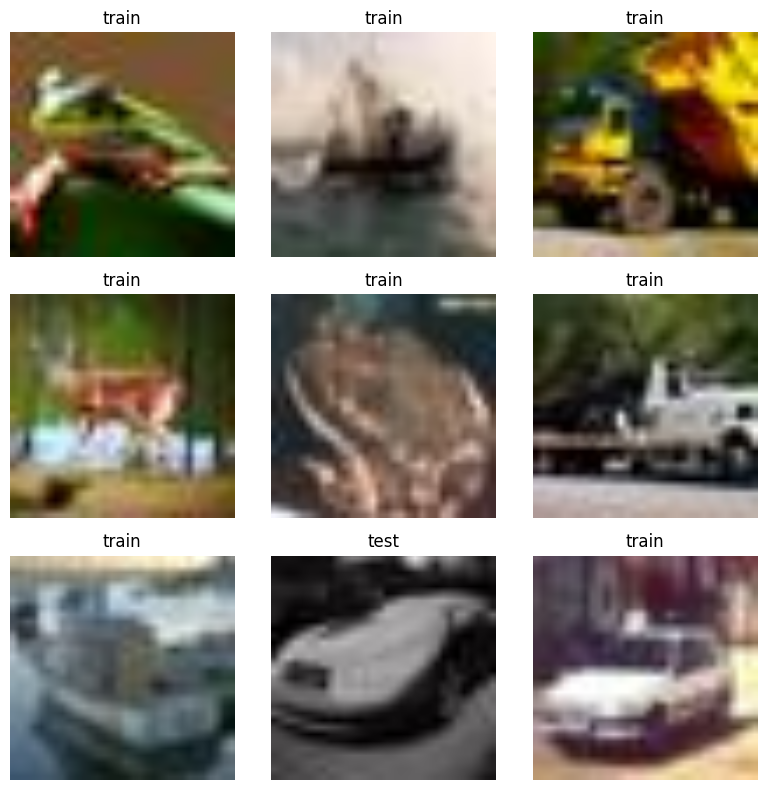

In [7]:
import matplotlib.pyplot as plt

for imgs, labels in train_ds.take(1):
    imgs = imgs.numpy().astype("uint8")
    labels = labels.numpy().astype(int)
    break

plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


Optimize the pipeline

In [11]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .cache('/tmp/tf_cache/train')
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .cache('/tmp/tf_cache/val')
    .prefetch(AUTOTUNE)
)


Data Augmentation

In [12]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


CNN

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=8,
    subset='training',
    class_mode='binary'
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=8,
    subset='validation',
    class_mode='binary'
)

model = models.Sequential([
    layers.Input((128,128,3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]




Found 96000 images belonging to 2 classes.
Found 24000 images belonging to 2 classes.


Train with callbacks

In [18]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 627s 52ms/step - accuracy: 0.8327 - loss: 0.4644 - val_accuracy: 0.8333 - val_loss: 0.4508
Epoch 2/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 573s 48ms/step - accuracy: 0.8338 - loss: 0.4512 - val_accuracy: 0.8333 - val_loss: 0.4515
Epoch 3/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 524s 44ms/step - accuracy: 0.8347 - loss: 0.4492 - val_accuracy: 0.8333 - val_loss: 0.4506
Epoch 4/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 527s 44ms/step - accuracy: 0.8339 - loss: 0.4503 - val_accuracy: 0.8333 - val_loss: 0.4506
Epoch 5/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 527s 44ms/step - accuracy: 0.8325 - loss: 0.4523 - val_accuracy: 0.8333 - val_loss: 0.4506
Epoch 6/20
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 561s 44ms/step - accuracy: 0.8315 - loss: 0.4537 - val_accuracy: 0.8333 - val_loss: 0.4506


# New Section

Plot all the curves

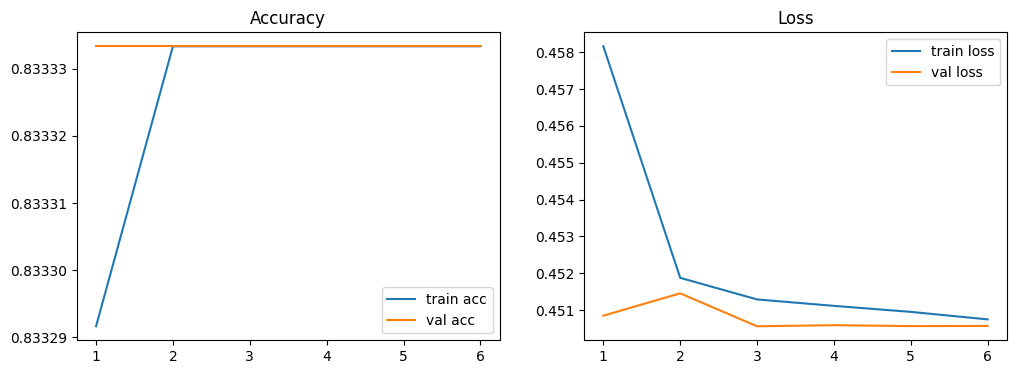

In [19]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc,    label='train acc')
plt.plot(epochs, val_acc, label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,     label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Loss')
plt.legend()

plt.show()


In [22]:
# Save your trained model
model.save('my_model.keras')

# Load it back
import tensorflow as tf
loaded_model = tf.keras.models.load_model('my_model.keras')

# Prepare a single image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np
img = 'bugatti.jpg'
img = image.load_img(img, target_size=(128,128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)  # shape (1,128,128,3)

# Run inference
pred = loaded_model.predict(img_array)[0][0]
label = 'REAL' if pred > 0.5 else 'FAKE'
print(label, pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
REAL 0.83223563
